In [74]:
import os
import numpy as np
from tqdm import  tqdm
import wave

win_len = 300
win_shift = int(win_len / 3)
win_type = 'hanning'
sigma = 1

def read_data(directory):
    audios = []
    labels = []
    max_frames = 0

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                label = int(file.split('_')[0])
                labels.append(label)
                
                file_path = os.path.join(root, file)
                with wave.open(file_path, 'rb') as signal:
                    n_channels, sampwidth, framerate, n_frames, comptype, compname = signal.getparams()
                    frames = signal.readframes(n_frames)
                    audio_data = np.frombuffer(frames, dtype=np.int16)
                    audios.append((audio_data, n_frames))
                    max_frames = max(max_frames, int(np.ceil(1 + (n_frames - win_len) / win_shift)))

    audios = np.array(audios, dtype=object)
    labels = np.array(labels)

    return audios, labels, max_frames

templates_directory = 'dtw/template/'
test_directory = 'dtw/test'
templates_audios, templates_labels, templates_longest = read_data(templates_directory)
test_audios, test_labels, test_longest = read_data(test_directory)

In [75]:
def framing(wave_data, nframes):
    if nframes < win_len:
        win_num = 1
    else:
        win_num = int(np.ceil(1 + (nframes - win_len) / win_shift))

    frames = np.zeros([win_num, win_len])

    for i in range(win_num):
        if i * win_shift + win_len <= nframes:
            frames[i, :] = wave_data[i * win_shift:i * win_shift + win_len]
        else:
            frames[i, :nframes - i * win_shift] = wave_data[i * win_shift:nframes]

    window = np.ones(win_len)

    if win_type == 'hanning':
        window = np.hanning(win_len)
    elif win_type == 'hamming':
        window = np.hamming(win_len)

    for i in range(win_num):
        frames[i, :] = window * frames[i, :]

    return frames

def pre_emphasis(signal, a=0.97):
    # H(z) = 1 - a*z^(-1)
    return np.append(signal[0], signal[1:] - a * signal[:-1])

def short_term_energy(signal):
    return np.sum(signal ** 2)

def zero_crossing_rate(signal):
    return np.sum(np.abs(np.diff(np.sign(signal)))) / 2

def short_term_amplitude(signal):
    return np.mean(np.abs(signal))

def preprocess(signals, longest):
    aligned_frames = []
    print('Feature extracting and end_point_detecting ...')
    for wave_data, nframes in tqdm(signals, total=len(signals)):
        # 预加重
        emphasized_signal = pre_emphasis(wave_data)
        
        frames = framing(emphasized_signal, nframes)
        if frames is None:
            continue
        frame_num = frames.shape[0]

        frame_features = []
        for frame in frames:
            energy = short_term_energy(frame)
            amplitude = short_term_amplitude(frame)
            zerorate = zero_crossing_rate(frame)
            frame_features.append([energy, amplitude, zerorate])

        MH = np.mean([f[0] for f in frame_features]) / sigma
        ML = np.mean([f[0] for f in frame_features[:5]])
        ZS = np.mean([f[2] for f in frame_features])

        frame_energy = np.array([f[0] for f in frame_features])
        zero_crossing = np.array([f[2] for f in frame_features])
        n3 = np.argmax(frame_energy > MH)
        n4 = len(frame_energy) - np.argmax(frame_energy[::-1] > MH) - 1

        n2 = n3 - np.argmax(frame_energy[:n3 + 1][::-1] <= ML)
        n5 = n4 + np.argmax(frame_energy[n4:] <= ML)

        n1 = n2 - np.argmax(zero_crossing[:n2 + 1][::-1] <= ZS)
        n6 = n5 + np.argmax(zero_crossing[n5:] <= ZS)

        if n5 == frame_num - 1:
            n6 = n5
        if n2 == 0:
            n1 = n2
        aligned_frame = np.zeros([longest, win_len])
        aligned_frame[0:n6 - n1 + 1,:] = frames[n1:n6 + 1]
        aligned_frames.append(frames)
    all_frames = np.array(aligned_frames)

    return all_frames

templates_frames = preprocess(templates_audios, templates_longest)
test_frames = preprocess(test_audios, test_longest)

Feature extracting and end_point_detecting ...


 60%|██████    | 6/10 [00:00<00:00, 20.81it/s]

100%|██████████| 10/10 [00:00<00:00, 20.89it/s]


Feature extracting and end_point_detecting ...


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


In [76]:
templates_frames.shape

(10, 1321, 300)

In [77]:
test_frames.shape

(1, 1321, 300)

In [78]:
def compute_fft(frames):
    return np.fft.rfft(frames, n=frames.shape[2], axis=2)

def compute_spectral_energy(fft_frames):
    return np.abs(fft_frames) ** 2


X_temp = compute_fft(templates_frames)
X_test = compute_fft(test_frames)
E_temp = compute_spectral_energy(X_temp)
E_test = compute_spectral_energy(X_test) 

In [79]:
E_temp.shape

(10, 1321, 151)

In [80]:
from scipy.fftpack import dct

sample_rate = 44100

def mel_filter_bank(num_filters, fft_size, sample_rate):
    low_freq_mel = 0
    high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((fft_size // 2 + 1) * hz_points / sample_rate).astype(int)

    filters = np.zeros((num_filters, int(fft_size // 2 + 1)))
    for m in range(1, num_filters + 1):
        f_m_minus = int(bin_points[m - 1])
        f_m = int(bin_points[m])
        f_m_plus = int(bin_points[m + 1])

        for k in range(f_m_minus, f_m):
            filters[m - 1, k] = (k - bin_points[m - 1]) / (bin_points[m] - bin_points[m - 1])
        for k in range(f_m, f_m_plus):
            filters[m - 1, k] = (bin_points[m + 1] - k) / (bin_points[m + 1] - bin_points[m])

    return filters

def compute_mfcc(spectral_energy, sample_rate, num_filters=40, num_ceps=12):
    fft_size = (spectral_energy.shape[-1] - 1) * 2
    mel_filters = mel_filter_bank(num_filters, fft_size, sample_rate)

    # 计算Mel滤波器能量
    # 这里需要将spectral_energy的最后一个维度与mel_filters进行点乘
    mel_energy = np.tensordot(spectral_energy, mel_filters.T, axes=([-1], [0]))
    mel_energy = np.where(mel_energy == 0, np.finfo(float).eps, mel_energy)
    log_mel_energy = np.log(mel_energy)

    # 应用DCT得到MFCC
    mfcc = dct(log_mel_energy, type=2, axis=-1, norm='ortho')[..., :num_ceps]
    return mfcc


mfcc_temp = compute_mfcc(E_temp, sample_rate)
mfcc_test = compute_mfcc(E_test, sample_rate)

In [81]:
mfcc_test.shape

(1, 1321, 12)

100%|██████████| 1320/1320 [00:17<00:00, 76.21it/s]


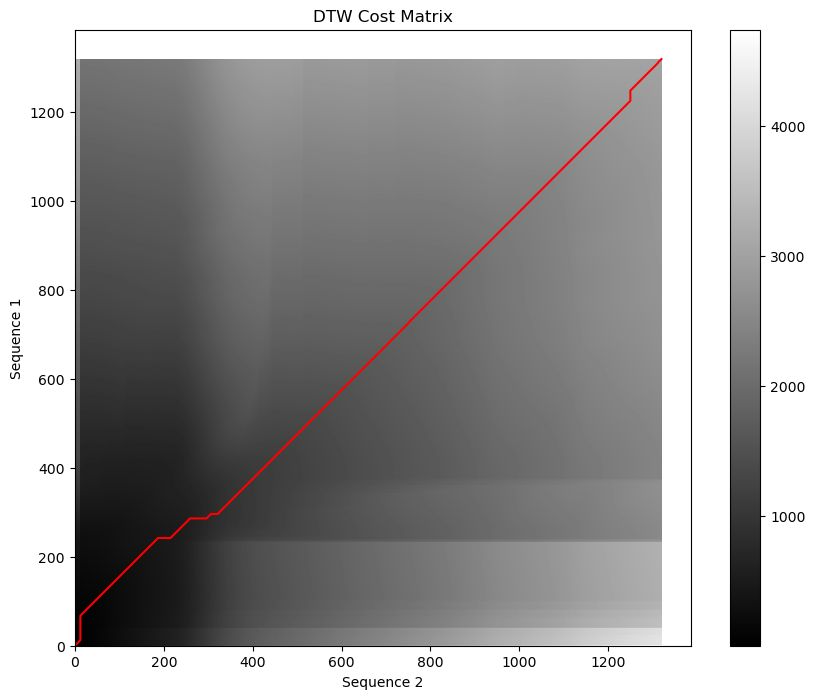

DTW Distance: 3039.1126685973763


In [87]:
import matplotlib.pyplot as plt

def euclidean_distance(x, y):
    return (1 / x.size) * np.sqrt(np.sum((x - y) ** 2))

def dtw(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n, m), np.inf)
    dtw_matrix[0, 0] = euclidean_distance(s1[0], s2[0])

    for i in range(1, n):
        dtw_matrix[i, 0] = dtw_matrix[i-1, 0] + euclidean_distance(s1[i], s2[0])
    for j in range(1, m):
        dtw_matrix[0, j] = dtw_matrix[0, j-1] + euclidean_distance(s1[0], s2[j])

    for i in tqdm(range(1, n)):
        for j in range(1, m):
            cost = euclidean_distance(s1[i], s2[j])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # Insertion
                                          dtw_matrix[i, j-1],    # Deletion
                                          dtw_matrix[i-1, j-1])  # Match

    return dtw_matrix

def plot_dtw(s1, s2, dtw_matrix, path):
    plt.figure(figsize=(10, 8))
    plt.imshow(dtw_matrix[1:, 1:], origin='lower', cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title('DTW Cost Matrix')
    plt.xlabel('Sequence 2')
    plt.ylabel('Sequence 1')
    plt.plot(path[:, 1], path[:, 0], 'r')  # Plot the path
    plt.show()

def compute_dtw_path(dtw_matrix):
    n, m = dtw_matrix.shape
    path = []
    i, j = n - 1, m - 1
    path.append((i, j))

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            steps = np.array([dtw_matrix[i-1, j-1], dtw_matrix[i-1, j], dtw_matrix[i, j-1]])
            step_index = np.argmin(steps)
            if step_index == 0:
                i, j = i-1, j-1
            elif step_index == 1:
                i -= 1
            else:
                j -= 1
        path.append((i, j))

    path.reverse()
    return np.array(path)

# 特征矩阵
s1 = mfcc_temp[0,:,:]
s2 = mfcc_test[0,:,:]

# Compute DTW
dtw_matrix = dtw(s1, s2)

# Compute DTW path
path = compute_dtw_path(dtw_matrix)

# Plot the DTW cost matrix with path
plot_dtw(s1, s2, dtw_matrix, path)

# Calculate and print the DTW distance
distance = dtw_matrix[len(s1)-1, len(s2)-1]
print("DTW Distance:", distance)


  1%|          | 9/1320 [00:00<00:16, 80.34it/s]

100%|██████████| 1320/1320 [00:17<00:00, 76.76it/s]


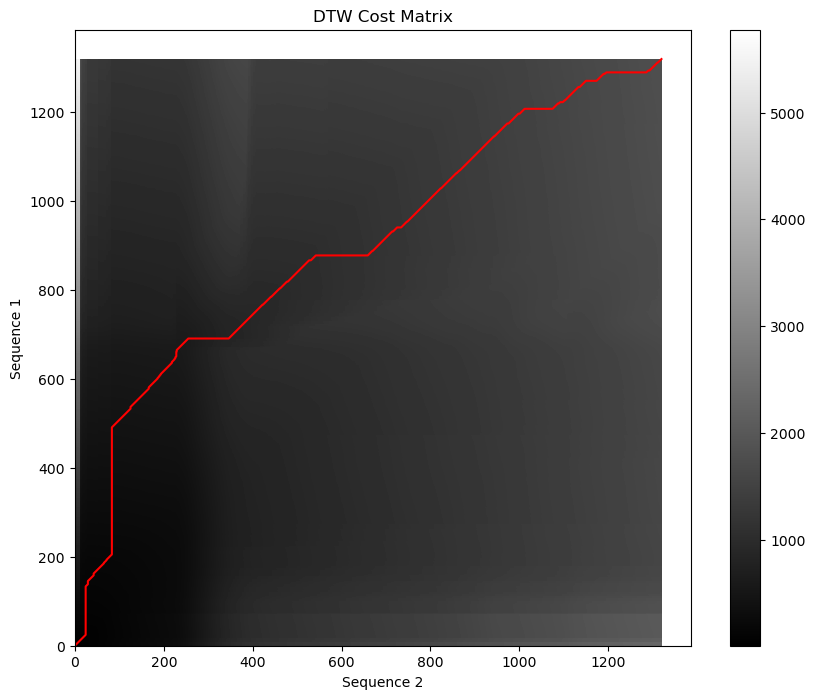

DTW Distance: 1791.704906446778


In [88]:
# 特征矩阵
s1 = mfcc_temp[2,:,:]
s2 = mfcc_test[0,:,:]

# Compute DTW
dtw_matrix = dtw(s1, s2)

# Compute DTW path
path = compute_dtw_path(dtw_matrix)

# Plot the DTW cost matrix with path
plot_dtw(s1, s2, dtw_matrix, path)

# Calculate and print the DTW distance
distance = dtw_matrix[len(s1)-1, len(s2)-1]
print("DTW Distance:", distance)

Feature extracting and end_point_detecting ...


100%|██████████| 10/10 [00:00<00:00, 156.77it/s]


Feature extracting and end_point_detecting ...


100%|██████████| 10/10 [23:41<00:00, 142.10s/it]


DTW Distance Matrix:
[[3118.16449146 2501.88296148 2948.02976166 1582.58046762 4994.93525878
  1641.97283159 3189.23556796 3039.1126686  2079.23926138 2475.94321036]
 [4040.44078986 2876.6247078  3869.14882965 1664.56623895 5914.58164357
  1586.12461335 4108.71392144 3765.05866553 1494.87957138 3080.25271715]
 [1603.16653172 2096.85422106 1548.77476687 3407.29977624 2316.53098582
  3298.0833872  1576.26153328 1791.70490645 3711.14022428 1981.84574376]
 [3267.28520633 2381.12904317 3047.45632259 1825.62437859 5260.16404968
  1790.55185076 3226.67203153 3315.90086758 1991.38764735 2426.32271006]
 [3533.72732214 2181.90608081 3341.6166735  1934.23290221 5359.25537741
  1804.27738929 3407.69963162 3232.56660497 1965.61316877 2214.19024009]
 [3234.83521101 2449.25700253 3072.01038295 1686.92130255 5291.28124433
  1712.60777408 3266.43777078 3308.57198904 1933.71443113 2499.09061581]
 [3243.13586861 2549.40636868 3086.21088124 1540.72320597 5227.05642884
  1696.29957618 3300.07221319 3227.47

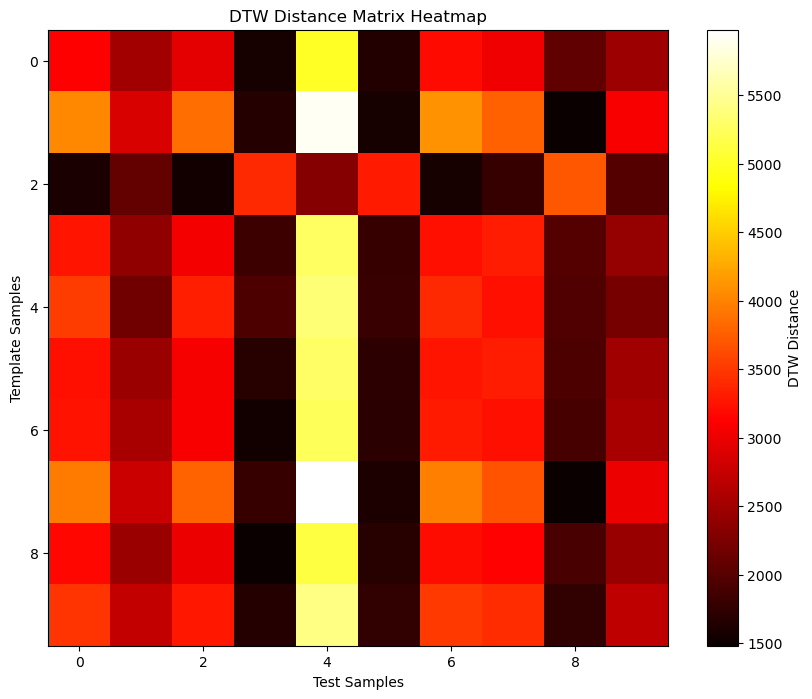

In [90]:
import os
import numpy as np
from tqdm import tqdm
import wave
from scipy.fftpack import dct
import matplotlib.pyplot as plt

sample_rate = 44100
win_len = 300
win_shift = int(win_len / 3)
win_type = 'hanning'
sigma = 1

def read_data(directory):
    audios = []
    labels = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                label = int(file.split('_')[0])
                labels.append(label)
                
                file_path = os.path.join(root, file)
                with wave.open(file_path, 'rb') as signal:
                    n_channels, sampwidth, framerate, n_frames, comptype, compname = signal.getparams()
                    frames = signal.readframes(n_frames)
                    audio_data = np.frombuffer(frames, dtype=np.int16)
                    audios.append((audio_data, n_frames))

    labels = np.array(labels)
    return audios, labels

def framing(wave_data, nframes):
    win_num = int(np.ceil(1 + (nframes - win_len) / win_shift))
    frames = np.zeros([win_num, win_len])

    for i in range(win_num):
        if i * win_shift + win_len <= nframes:
            frames[i, :] = wave_data[i * win_shift:i * win_shift + win_len]
        else:
            frames[i, :nframes - i * win_shift] = wave_data[i * win_shift:nframes]

    window = np.ones(win_len)

    if win_type == 'hanning':
        window = np.hanning(win_len)
    elif win_type == 'hamming':
        window = np.hamming(win_len)

    for i in range(win_num):
        frames[i, :] = window * frames[i, :]

    return frames

def pre_emphasis(signal, a=0.97):
    return np.append(signal[0], signal[1:] - a * signal[:-1])

def preprocess(signals):
    all_frames = []
    print('Feature extracting and end_point_detecting ...')
    for wave_data, nframes in tqdm(signals, total=len(signals)):
        emphasized_signal = pre_emphasis(wave_data)
        frames = framing(emphasized_signal, nframes)
        all_frames.append(frames)
    return all_frames

def compute_fft(frames):
    return [np.fft.rfft(frame, n=frame.shape[1], axis=1) for frame in frames]

def compute_spectral_energy(fft_frames):
    return [np.abs(frame) ** 2 for frame in fft_frames]

def mel_filter_bank(num_filters, fft_size, sample_rate):
    low_freq_mel = 0
    high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((fft_size // 2 + 1) * hz_points / sample_rate).astype(int)

    filters = np.zeros((num_filters, int(fft_size // 2 + 1)))
    for m in range(1, num_filters + 1):
        f_m_minus = int(bin_points[m - 1])
        f_m = int(bin_points[m])
        f_m_plus = int(bin_points[m + 1])

        for k in range(f_m_minus, f_m):
            filters[m - 1, k] = (k - bin_points[m - 1]) / (bin_points[m] - bin_points[m - 1])
        for k in range(f_m, f_m_plus):
            filters[m - 1, k] = (bin_points[m + 1] - k) / (bin_points[m + 1] - bin_points[m])

    return filters

def compute_mfcc(spectral_energy, sample_rate, num_filters=40, num_ceps=12):
    mfccs = []
    for energy in spectral_energy:
        fft_size = (energy.shape[-1] - 1) * 2
        mel_filters = mel_filter_bank(num_filters, fft_size, sample_rate)
        mel_energy = np.tensordot(energy, mel_filters.T, axes=([-1], [0]))
        mel_energy = np.where(mel_energy == 0, np.finfo(float).eps, mel_energy)
        log_mel_energy = np.log(mel_energy)
        mfcc = dct(log_mel_energy, type=2, axis=-1, norm='ortho')[..., :num_ceps]
        mfccs.append(mfcc)
    return mfccs

def euclidean_distance(x, y):
    return (1 / x.size) * np.sqrt(np.sum((x - y) ** 2))

def dtw(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n, m), np.inf)
    dtw_matrix[0, 0] = euclidean_distance(s1[0], s2[0])

    for i in range(1, n):
        dtw_matrix[i, 0] = dtw_matrix[i-1, 0] + euclidean_distance(s1[i], s2[0])
    for j in range(1, m):
        dtw_matrix[0, j] = dtw_matrix[0, j-1] + euclidean_distance(s1[0], s2[j])

    for i in range(1, n):
        for j in range(1, m):
            cost = euclidean_distance(s1[i], s2[j])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # Insertion
                                          dtw_matrix[i, j-1],    # Deletion
                                          dtw_matrix[i-1, j-1])  # Match

    return dtw_matrix

def plot_dtw(s1, s2, dtw_matrix, path):
    plt.figure(figsize=(10, 8))
    plt.imshow(dtw_matrix[1:, 1:], origin='lower', cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title('DTW Cost Matrix')
    plt.xlabel('Sequence 2')
    plt.ylabel('Sequence 1')
    plt.plot(path[:, 1], path[:, 0], 'r')  # Plot the path
    plt.show()

def compute_dtw_path(dtw_matrix):
    n, m = dtw_matrix.shape
    path = []
    i, j = n - 1, m - 1
    path.append((i, j))

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            steps = np.array([dtw_matrix[i-1, j-1], dtw_matrix[i-1, j], dtw_matrix[i, j-1]])
            step_index = np.argmin(steps)
            if step_index == 0:
                i, j = i-1, j-1
            elif step_index == 1:
                i -= 1
            else:
                j -= 1
        path.append((i, j))

    path.reverse()
    return np.array(path)

def compute_dtw_distance(templates, tests):
    num_templates = len(templates)
    num_tests = len(tests)
    distance_matrix = np.zeros((num_templates, num_tests))

    for i in tqdm(range(num_templates)):
        for j in range(num_tests):
            s1 = templates[i]
            s2 = tests[j]
            
            # Compute DTW
            dtw_matrix = dtw(s1, s2)
            
            # Calculate DTW distance
            distance = dtw_matrix[-1, -1]
            distance_matrix[i, j] = distance
    
    return distance_matrix

def plot_distance_matrix(distance_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(distance_matrix, interpolation='nearest', cmap='hot', aspect='auto')
    plt.title("DTW Distance Matrix Heatmap")
    plt.xlabel("Test Samples")
    plt.ylabel("Template Samples")
    plt.colorbar(label='DTW Distance')
    plt.show()

templates_directory = 'dtw/template/'
test_directory = 'dtw/test'
templates_audios, templates_labels = read_data(templates_directory)
test_audios, test_labels = read_data(test_directory)
templates_frames = preprocess(templates_audios)
test_frames = preprocess(test_audios)
X_temp = compute_fft(templates_frames)
X_test = compute_fft(test_frames)
E_temp = compute_spectral_energy(X_temp)
E_test = compute_spectral_energy(X_test) 
mfcc_temp = compute_mfcc(E_temp, sample_rate)
mfcc_test = compute_mfcc(E_test, sample_rate)
# Compute DTW distance matrix
distance_matrix = compute_dtw_distance(mfcc_temp, mfcc_test)

# Print the DTW distance matrix
print("DTW Distance Matrix:")
print(distance_matrix)
plot_distance_matrix(distance_matrix)

